# [GD8]Segmentation U-net

## 실습목표
1. 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
2. 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
3. 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

## 세부내용
 - KITTY 세그멘테이션 데이터셋 전처리
 - U-net 모델 생성
 - U-net IoU 값 확인
 - U-net++ 모델 생성
 - U-net++ Iou 값 확인
 - 결과정리

In [15]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



In [16]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

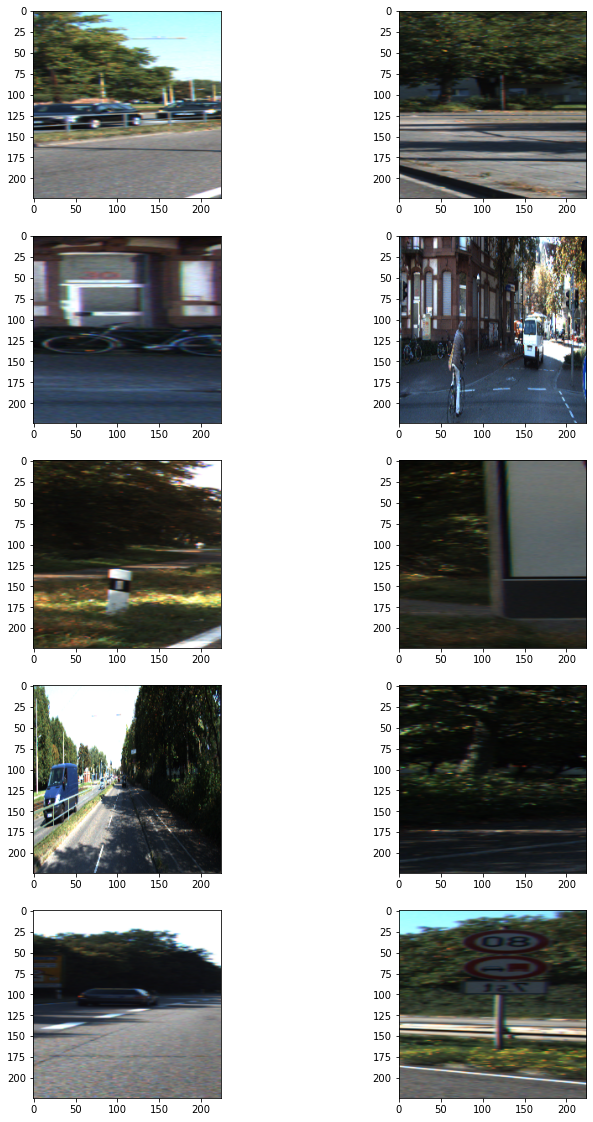

In [17]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()


 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [18]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [19]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-net 모델 구조 만들기

In [41]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

모델 학습하기

In [42]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
43/43 [==============================] - 23s 224ms/step - loss: 0.6114 - val_loss: 0.1534
Epoch 2/100
43/43 [==============================] - 9s 205ms/step - loss: 0.1353 - val_loss: 0.0899
Epoch 3/100
43/43 [==============================] - 9s 204ms/step - loss: 0.0874 - val_loss: 0.0852
Epoch 4/100
43/43 [==============================] - 9s 206ms/step - loss: 0.0773 - val_loss: 0.0767
Epoch 5/100
43/43 [==============================] - 9s 206ms/step - loss: 0.0672 - val_loss: 0.0717
Epoch 6/100
43/43 [==============================] - 9s 206ms/step - loss: 0.0700 - val_loss: 0.0751
Epoch 7/100
43/43 [==============================] - 9s 206ms/step - loss: 0.0649 - val_loss: 0.0883
Epoch 8/100
43/43 [==============================] - 9s 207ms/step - loss: 0.0922 - val_loss: 0.0866
Epoch 9/100
43/43 [==============================] - 9s 207ms/step - loss: 0.0940 - val_loss: 0.0758
Epoch 10/100
43/43 [==============================] - 9s 208ms/step - loss: 0.0986 - val_l

43/43 [==============================] - 9s 209ms/step - loss: 0.0483 - val_loss: 0.1073
Epoch 82/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0642 - val_loss: 0.0690
Epoch 83/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0557 - val_loss: 0.0723
Epoch 84/100
43/43 [==============================] - 9s 210ms/step - loss: 0.0512 - val_loss: 0.0708
Epoch 85/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0610 - val_loss: 0.0684
Epoch 86/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0472 - val_loss: 0.0617
Epoch 87/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0474 - val_loss: 0.0656
Epoch 88/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0468 - val_loss: 0.0661
Epoch 89/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0599 - val_loss: 0.0659
Epoch 90/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0547 - val_loss: 

In [43]:
model_path = dir_path + '/seg_model_unet.h5'

In [44]:
model.save(model_path)  #학습한 모델을 저장해 주세요.

## 시맨틱 세그멘테이션 모델 시각화

In [26]:
model = tf.keras.models.load_model(model_path)

In [27]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [28]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score


In [29]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [30]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)


IoU : 0.833772


0.833771773906861

## 개선된 U-Net 모델 만들기
https://www.kaggle.com/ekhtiar/tf-tutorial-semantic-segmentation-with-u-net

In [35]:
from keras.regularizers import l2


def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'
    smooth = 1.
    dropout_rate = 0.5
    
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

def build_model_nested_unet(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  nb_filter = [32,64,128,256,512]
  act = 'elu'

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2)
  conv1_2 = concatenate([up1_2, conv1], name='merge12', axis=3)
  conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])    
        
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3)
  conv2_2 = concatenate([up2_2, conv2], name='merge22', axis=3)
  conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

  up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
  conv1_3 = concatenate([up1_3, conv1, conv1_2], name='merge13', axis=3)
  conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4)
  conv3_2 = concatenate([up3_2, conv3], name='merge32', axis=3)
  conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

  up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
  conv2_3 = concatenate([up2_3, conv2, conv2_2], name='merge23', axis=3)
  conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

  up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
  conv1_4 = concatenate([up1_4, conv1, conv1_2, conv1_3], name='merge14', axis=3)
  conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5)
  conv4_2 = concatenate([up4_2, conv4], name='merge42', axis=3)
  conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

  up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
  conv3_3 = concatenate([up3_3, conv3, conv3_2], name='merge33', axis=3)
  conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

  up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
  conv2_4 = concatenate([up2_4, conv2, conv2_2, conv2_3], name='merge24', axis=3)
  conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

  up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
  conv1_5 = concatenate([up1_5, conv1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
  conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
   
  nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
  nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
  nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
  nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)    
    
    #Expanding Path
  #drop5 = Dropout(0.5)(conv5)
  #up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  #merge6 = concatenate([drop4,up6], axis = 3)
  #conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  #conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  #up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  #merge7 = concatenate([conv3,up7], axis = 3)
  #conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  #conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  #up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  #merge8 = concatenate([conv2,up8], axis = 3)
  #conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  #conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  #up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  #merge9 = concatenate([conv1,up9], axis = 3)
  #conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  #conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  #conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  #conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  #model = Model(inputs = inputs, outputs = conv10)
  model = Model(inputs=inputs, outputs=[nestnet_output_4])
  return model

In [36]:
model = build_model_nested_unet()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
43/43 [==============================] - 12s 226ms/step - loss: 0.9218 - val_loss: 0.4434
Epoch 2/100
43/43 [==============================] - 10s 224ms/step - loss: 0.4966 - val_loss: 0.4113
Epoch 3/100
43/43 [==============================] - 10s 229ms/step - loss: 0.4354 - val_loss: 0.3910
Epoch 4/100
43/43 [==============================] - 10s 229ms/step - loss: 0.3662 - val_loss: 0.4464
Epoch 5/100
43/43 [==============================] - 10s 230ms/step - loss: 0.4109 - val_loss: 0.3211
Epoch 6/100
43/43 [==============================] - 10s 230ms/step - loss: 0.3392 - val_loss: 0.4605
Epoch 7/100
43/43 [==============================] - 10s 231ms/step - loss: 0.3804 - val_loss: 0.3126
Epoch 8/100
43/43 [==============================] - 10s 231ms/step - loss: 0.3208 - val_loss: 0.3113
Epoch 9/100
43/43 [==============================] - 10s 232ms/step - loss: 0.3164 - val_loss: 0.2978
Epoch 10/100
43/43 [==============================] - 10s 232ms/step - loss: 0.302

43/43 [==============================] - 10s 233ms/step - loss: 0.1043 - val_loss: 0.1021
Epoch 81/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0867 - val_loss: 0.1036
Epoch 82/100
43/43 [==============================] - 10s 234ms/step - loss: 0.0891 - val_loss: 0.1078
Epoch 83/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0982 - val_loss: 0.1223
Epoch 84/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0858 - val_loss: 0.1270
Epoch 85/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0856 - val_loss: 0.1108
Epoch 86/100
43/43 [==============================] - 10s 232ms/step - loss: 0.0910 - val_loss: 0.0962
Epoch 87/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0835 - val_loss: 0.1039
Epoch 88/100
43/43 [==============================] - 10s 232ms/step - loss: 0.0917 - val_loss: 0.0924
Epoch 89/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0980 - 

In [37]:
model_path_nested_unet = dir_path + '/seg_model_nested_unet.h5'

In [38]:
model.save(model_path_nested_unet)  #학습한 모델을 저장해 주세요.

In [39]:
model_nested_unet = tf.keras.models.load_model(model_path_nested_unet)

In [40]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_nested_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.862064


0.8620641268504876

# 루브릭
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한사이클이 정상수행되어 세그멘테이션 결과이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?
U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
U-Net++ 의 세그멘테이션 결과 사진와 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

# 결과
 - U-net IoU : 0.833772
 - U-net ++  IoU : 0.862064

 
